### Style Transfer

In [1]:
from fastai.vision.all import *

In [2]:
data_path = 'C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/'

In [3]:
from torchvision.models import vgg16, vgg19

In [4]:
feat_net = vgg19(pretrained=True).features.cuda().eval()

In [5]:
for p in feat_net.parameters(): p.requires_grad=False

In [6]:
layers = [feat_net[i] for i in [1,6,11,20,29,22]]; layers

[ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True)]

In [7]:
_vgg_config = {
    'vgg16':[1,11,18,25,20],
    'vgg19':[1,6,11,20,29,22]
}

In [8]:
def _get_layers(arch:str,pretrained=True):
    feat_net = vgg19(pretrained=pretrained).cuda() if arch.find('9') > 1 else vgg16(pretrained=pretrained).cuda()
    config = _vgg_config.get(arch)
    features = feat_net.features.cuda().eval()
    for p in features.parameters(): p.requires_grad=False
    return feat_net, [features[i] for i in config]

In [9]:
def get_feats(arch:str,pretrained=True):
    feat_net, layers = _get_layers(arch,pretrained)
    hooks = hook_outputs(layers,detach=False)
    def _inner(x):
        feat_net(x)
        return hooks.stored
    return _inner

In [10]:
feats = get_feats('vgg19')

In [11]:
fn = 'style.jpg'

In [12]:
dset = Datasets(fn, tfms=[PILImage.create])

In [13]:
dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


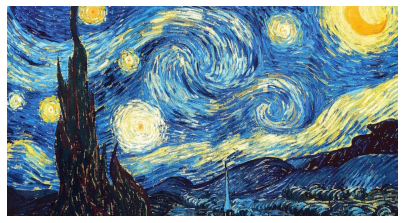

In [14]:
dl.show_batch(figsize=(7,7))

In [15]:
style_im = dl.one_batch()[0]

In [16]:
style_im.shape

torch.Size([1, 3, 373, 696])

In [17]:
im_feats = feats(style_im)

In [18]:
for feat in im_feats:
    print(feat.shape)

torch.Size([1, 64, 373, 696])
torch.Size([1, 128, 186, 348])
torch.Size([1, 256, 93, 174])
torch.Size([1, 512, 46, 87])
torch.Size([1, 512, 23, 43])
torch.Size([1, 512, 46, 87])


In [19]:
def gram(x:Tensor):
    n,c,h,w=x.shape
    x=x.view(n,c,-1)
    return (x@x.transpose(1,2))/(c*w*h)

In [20]:
im_grams = [gram(f) for f in im_feats]

In [21]:
for feat in im_grams:
    print(feat.shape)

torch.Size([1, 64, 64])
torch.Size([1, 128, 128])
torch.Size([1, 256, 256])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


In [22]:
def get_stl_fs(fs): return fs[:-1]

In [23]:
def style_loss(inp:Tensor, out_feat:Tensor):
    bs=inp[0].shape[0]
    loss=[]
    for y, f in zip(*map(get_stl_fs, [im_grams, inp])):
        loss.append(F.mse_loss(y.repeat(bs,1,1), gram(f)))
    return 3e5*sum(loss)

In [24]:
class FeatureLoss(Module):
    def __init__(self, feats, style_loss, act_loss):
        store_attr()
        self.reset_metrics()
        
    def forward(self, pred, targ):
        pred_feat, targ_feat = self.feats(pred), self.feats(targ)
        style_loss = self.style_loss(pred_feat, targ_feat)
        act_loss = self.act_loss(pred_feat, targ_feat)
        self._add_loss(style_loss, act_loss)
        return style_loss + act_loss
    
    def reset_metrics(self):
        self.metrics = dict(style=[],content=[])
        
    def _add_loss(self, style_loss, act_loss):
        self.metrics['style'].append(style_loss)
        self.metrics['content'].append(act_loss)

In [25]:
def act_loss(inp:Tensor, targ:Tensor):
    return F.mse_loss(inp[-1], targ[-1])

In [26]:
loss_func = FeatureLoss(feats, style_loss, act_loss)

In [27]:
class ReflectionLayer(Module):
    def __init__(self,in_channels,out_channels,ks=3,stride=2):
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels,out_channels,ks,stride)
        
    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [28]:
ReflectionLayer(3, 3)

ReflectionLayer(
  (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
  (conv2d): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2))
)

In [29]:
class ResidualBlock(Module):
    def __init__(self,channels):
        self.conv1 = ReflectionLayer(channels, channels, ks=3, stride=1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ReflectionLayer(channels, channels, ks=3, stride=1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out

In [30]:
ResidualBlock(3)

ResidualBlock(
  (conv1): ReflectionLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  )
  (in1): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ReflectionLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  )
  (in2): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (relu): ReLU()
)

In [31]:
class UpsampleConvLayer(Module):
    def __init__(self,in_channels,out_channels,ks=3,stride=2,upsample=None):
        self.upsample = upsample
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels,out_channels,ks,stride)
        
    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in,mode='nearest',scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [32]:
class TransformerNet(Module):
    def __init__(self):
        self.conv1 = ReflectionLayer(3, 32, ks=9, stride=1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ReflectionLayer(32, 64, ks=3, stride=2)
        self.in2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ReflectionLayer(64, 128, ks=3, stride=2)
        self.in3 = nn.InstanceNorm2d(128, affine=True)
        
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        
        self.deconv1 = UpsampleConvLayer(128, 64, ks=3, stride=1, upsample=2)
        self.in4 = nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, ks=3, stride=1, upsample=2)
        self.in5 = nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ReflectionLayer(32, 3, ks=9, stride=1)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        y = self.relu(self.in1(self.conv1(x)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y

In [33]:
net = TransformerNet()

In [34]:
path = untar_data(URLs.COCO_SAMPLE)

In [34]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(224)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [35]:
dls = dblock.dataloaders(path, bs=8, num_workers=0)

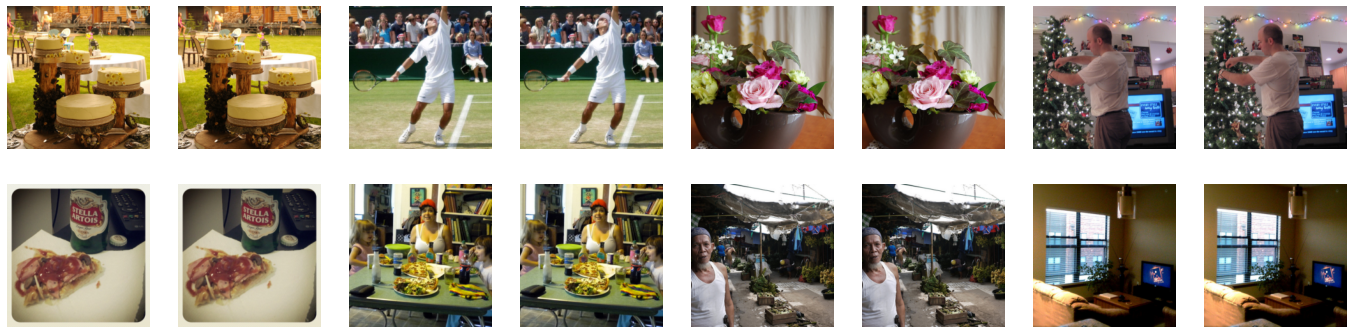

In [36]:
dls.show_batch()

In [37]:
learn = Learner(dls, TransformerNet(), loss_func=loss_func)

In [38]:
learn.summary()

TransformerNet (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     []                  
ReflectionPad2d                                                
____________________________________________________________________________
                     8 x 32 x 224 x 224  
Conv2d                                    7808       True      
InstanceNorm2d                            64         True      
____________________________________________________________________________
                     []                  
ReflectionPad2d                                                
____________________________________________________________________________
                     8 x 64 x 112 x 112  
Conv2d                                    18496      True      
InstanceNorm2d                            128        True      
____________________________________________________________________________
                     []                  
Re

SuggestedLRs(valley=6.30957365501672e-05)

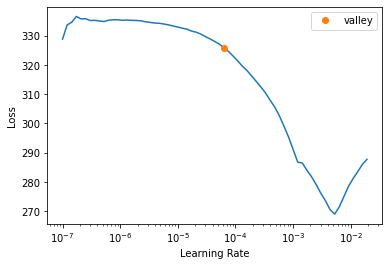

In [39]:
learn.lr_find()

In [40]:
learn.fit_one_cycle(1, 1e-3)

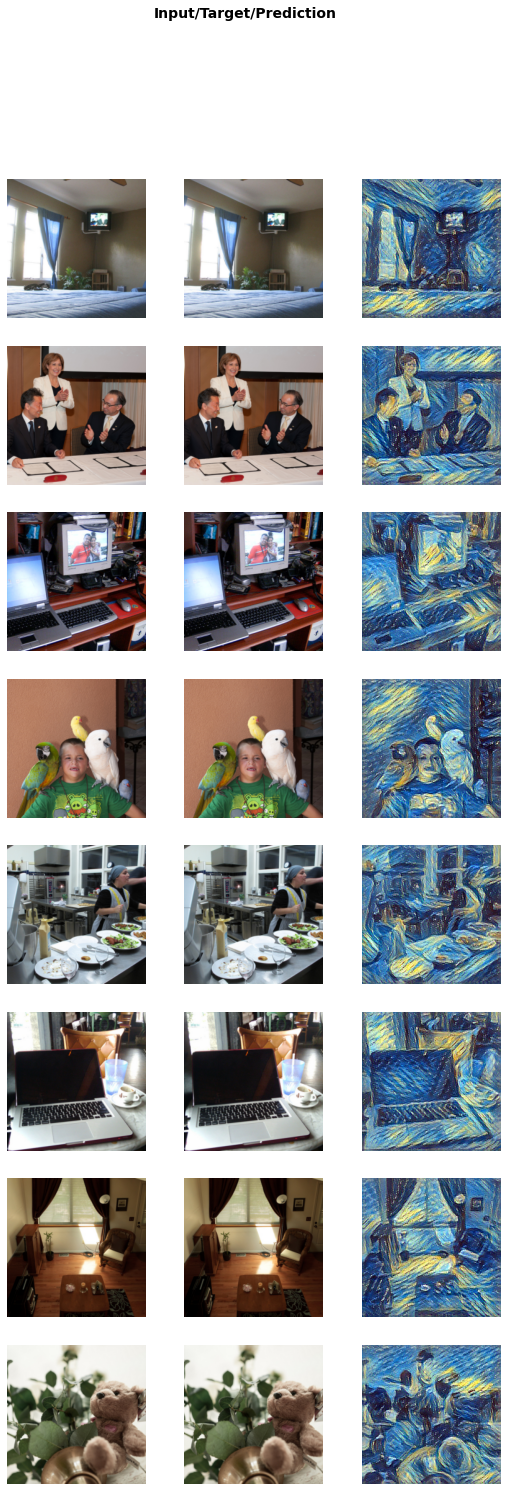

In [41]:
learn.show_results()

In [34]:
learn.save(data_path + 'style_stage_1')

In [43]:
pred = learn.predict('cat.jpg')

<AxesSubplot:>

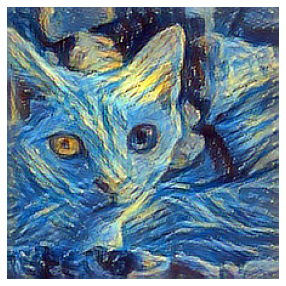

In [44]:
pred[0].show()

In [45]:
learn.load(data_path + 'style_stage_1')

In [46]:
dset = Datasets('cat.jpg', tfms=[PILImage.create])
dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [47]:
t_im = dl.one_batch()[0]

In [48]:
with torch.no_grad():
    res = learn.model(t_im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

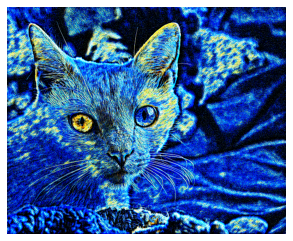

In [49]:
TensorImage(res[0]).show()

<AxesSubplot:>

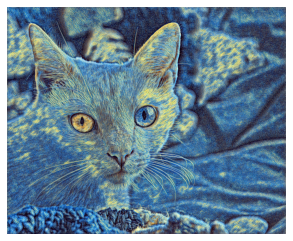

In [50]:
dec_res = dl.decode_batch(tuplify(res))[0][0]
dec_res.show()

In [ ]:
learn.save(data_path + 'style_224')

In [35]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(448)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [36]:
dls = dblock.dataloaders(path, bs=4, num_workers=0)

In [37]:
learn = Learner(dls, net, loss_func=loss_func).load(data_path + 'style_224')

In [38]:
learn.fit_one_cycle(1, 1e-3)

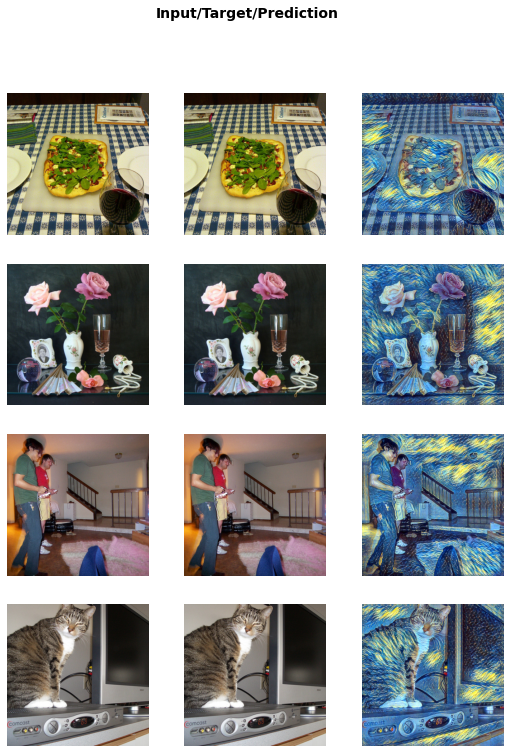

In [39]:
learn.show_results()

In [40]:
learn.save(data_path + 'style_final')

Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/style_final.pth')

In [41]:
learn.loss_func = CrossEntropyLossFlat()

### EfficientNet

In [1]:
from fastai.vision.all import *
from fastai.vision.learner import _update_first_layer
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/Fruit/train')

In [3]:
item_tfms = RandomResizedCrop(460, min_scale=0.75)
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]

In [4]:
fruits = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=parent_label,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

In [5]:
dls = fruits.dataloaders(path, bs=32,num_workers=0)

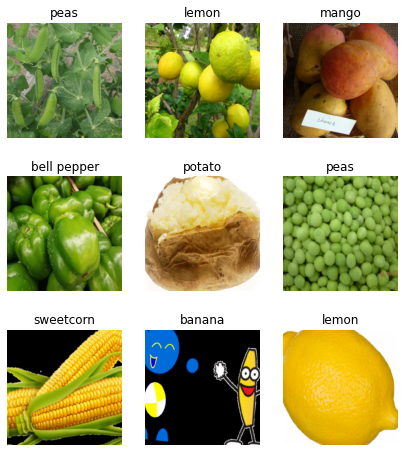

In [6]:
dls.show_batch(max_n=9,figsize=(7,8))

In [7]:
!pip install timm

In [8]:
from timm import create_model

In [8]:
net = create_model('efficientnet_b3a', pretrained=True)

In [10]:
learn = cnn_learner(dls, resnet18)

In [11]:
learn.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=36, bias=False)
)

In [12]:
net[-1]

TypeError: 'EfficientNet' object is not subscriptable

In [13]:
len(learn.model)

2

In [14]:
len(net)

TypeError: object of type 'EfficientNet' has no len()

In [15]:
create_head(2048,10)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

In [16]:
net

EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
 

In [17]:
body = create_body(net, pretrained=False, cut=-1)

TypeError: forward() got an unexpected keyword argument 'pretrained'

In [7]:
def create_timm_body(arch:str,pretrained=True,cut=None,n_in=3):
    model = create_model(arch, pretrained=pretrained,num_classes=0,global_pool='')
    _update_first_layer(model,n_in,pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut,int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [10]:
body = create_timm_body('efficientnet_b3a',pretrained=True)

In [11]:
len(body)

7

In [12]:
body

Sequential(
  (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
  (3): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): De

In [13]:
nf = num_features_model(nn.Sequential(*body.children())); nf

1536

In [14]:
head = create_head(nf, dls.c)

In [15]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(3072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=3072, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=36, bias=False)
)

In [16]:
model = nn.Sequential(body, head)

In [17]:
apply_init(model[1],nn.init.kaiming_normal_)

In [18]:
len(model)

2

In [19]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy())

In [20]:
learn.summary()

Sequential (Input shape: 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 40 x 112 x 112 
Conv2d                                    1080       True      
BatchNorm2d                               80         True      
SiLU                                                           
Conv2d                                    360        True      
BatchNorm2d                               80         True      
SiLU                                                           
____________________________________________________________________________
                     32 x 10 x 1 x 1     
Conv2d                                    410        True      
SiLU                                                           
____________________________________________________________________________
                     32 x 40 x 1 x 1     
Conv2d                                    440        True      
Sigmoid                                            

In [21]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(),splitter=default_split,metrics=error_rate)

In [22]:
learn.freeze()
learn.summary()

Sequential (Input shape: 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 40 x 112 x 112 
Conv2d                                    1080       False     
BatchNorm2d                               80         True      
SiLU                                                           
Conv2d                                    360        False     
BatchNorm2d                               80         True      
SiLU                                                           
____________________________________________________________________________
                     32 x 10 x 1 x 1     
Conv2d                                    410        False     
SiLU                                                           
____________________________________________________________________________
                     32 x 40 x 1 x 1     
Conv2d                                    440        False     
Sigmoid                                            

SuggestedLRs(valley=0.002511886414140463)

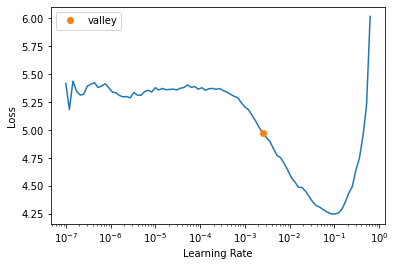

In [23]:
learn.lr_find()

In [24]:
learn.fit_one_cycle(5, slice(3e-2))

In [21]:
data_path = 'C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/'
#learn.save(data_path + 'eff_stage_1')

SuggestedLRs(valley=4.365158383734524e-05)

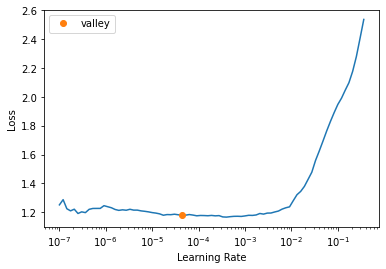

In [26]:
learn.unfreeze()
learn.lr_find()

In [27]:
learn.fit_one_cycle(5, slice(1e-4))

In [28]:
learn.save(data_path + 'eff_model_2')

Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/eff_model_2.pth')

In [3]:
path = untar_data(URLs.IMAGENETTE_160)
tfms = [[PILImage.create],[parent_label, Categorize()]]
item_tfms = [ToTensor(), Resize(128)]
batch_tfms = [FlipItem(), RandomResizedCrop(128, min_scale=0.35),
              IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

In [4]:
items = get_image_files(path)
split_idx = GrandparentSplitter(valid_name='val')(items)
dsets = Datasets(items, tfms, splits=split_idx)
dls = dsets.dataloaders(after_item=item_tfms,after_batch=batch_tfms,bs=64, num_workers=0)

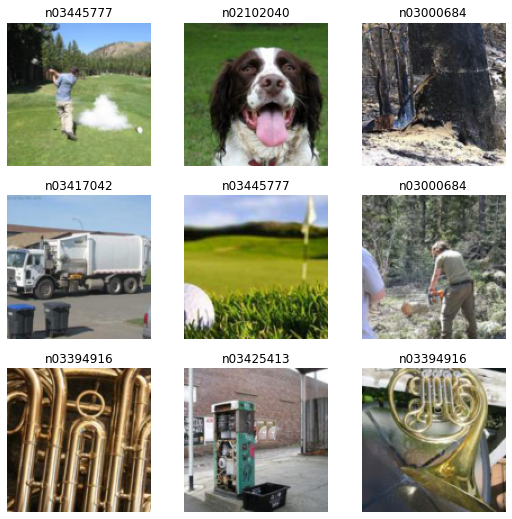

In [5]:
dls.show_batch()

In [10]:
body = create_timm_body('efficientnet_b3a', pretrained=False)
head = create_head(1536, dls.c)
model = nn.Sequential(body, head)
apply_init(model[1], nn.init.kaiming_normal_)

In [11]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), splitter=default_split, metrics=accuracy)

In [12]:
learn.model.state_dict()

OrderedDict([('0.0.weight',
              tensor([[[[-0.1024, -0.1050,  0.1152],
                        [-0.0224, -0.0591, -0.0272],
                        [-0.0734, -0.0038,  0.0447]],
              
                       [[-0.0417,  0.0730, -0.0096],
                        [-0.0269,  0.1374, -0.0533],
                        [ 0.0633, -0.0420,  0.0478]],
              
                       [[-0.0943,  0.1198, -0.0464],
                        [-0.0699, -0.0056,  0.0067],
                        [ 0.0601, -0.1171,  0.0500]]],
              
              
                      [[[-0.0885,  0.1338, -0.1082],
                        [-0.0341, -0.0006, -0.0158],
                        [-0.0325, -0.0382, -0.0486]],
              
                       [[ 0.0859,  0.0664,  0.0552],
                        [ 0.0083, -0.0036,  0.0627],
                        [ 0.0130, -0.0573,  0.1212]],
              
                       [[ 0.1311,  0.1272,  0.0113],
                        [ 0.

In [13]:
learn.model_dir

'models'

In [29]:
def transfer_learn(learn:Learner,name:Path,device:torch.device=None):
    if device is None: device = learn.dls.device
    learn.model_dir = Path(learn.model_dir)
    if (learn.model_dir/name).with_suffix('.pth'): model_path = (learn.model_dir/name).with_suffix('.pth')
    else: model_path = name
    new_state_dict = torch.load(model_path, map_location=device)['model']
    learn_state_dict = learn.model.state_dict()
    for name, param in learn_state_dict.items():
        if name in new_state_dict:
            input_param = new_state_dict[name]
            if input_param.shape == param.shape:
                param.copy_(input_param)
            else:
                print('Shape mismatch at: ', name, 'skipping')
        else:
            print(f'{name} weight of the model not in pretrained weights')
    learn.model.load_state_dict(learn_state_dict)
    return learn

In [30]:
learn = transfer_learn(learn, data_path + 'eff_stage_1')

Shape mismatch at:  1.8.weight skipping


In [31]:
learn.model[1][8]

Linear(in_features=512, out_features=10, bias=False)

In [32]:
learn.freeze()

In [33]:
learn.fit_one_cycle(5, 3e-3)

In [34]:
body = create_timm_body('efficientnet_b3a', pretrained=False)
head = create_head(1536, dls.c)
model = nn.Sequential(body, head)
apply_init(model[1], nn.init.kaiming_normal_)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), splitter=default_split, metrics=accuracy)
learn.freeze()
learn.fit_one_cycle(5, 3e-3)